# Макар Кулишенко
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
14709,21682,66634,NaN,23-03-2020,Still zero delivery slots or ÃÂclick &amp; c...,Extremely Negative
9344,15145,60097,"Illinois, USA",20-03-2020,#Banks Pressure #HealthCare Firms to Raise Pri...,Negative
9004,14732,59684,"Dundee, Fife & elsewhere",20-03-2020,Someone telling me a story earlier about a hom...,Extremely Negative
20686,29036,73988,"Los Angeles, CA / Atlanta. GA",31-03-2020,NO #covid_19 HERE. Just taking this time to de...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
def encoding(sent: str):
  if 'positive' in sent.lower():
    return 1
  return 0


df['Sentiment'] = df['Sentiment'].apply(encoding)
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3118,7573,52525,"New Jersey, USA",18-03-2020,"Every person I spoke to today, whether at 7-11...",1
15440,22585,67537,NaN,23-03-2020,as my first tweet i would like to take the lib...,0
27407,37408,82360,"Ahmadabad City, India",08-04-2020,#BMW has started online shopping for their CAR...,1
8639,14294,59246,"England, United Kingdom",20-03-2020,Just braved my local supermarket for the first...,1


Сбалансированы ли классы?

In [4]:
print(f"Negative : {len(df[df['Sentiment'] == 0])}\nPositive :  {len(df[df['Sentiment'] == 1])}")

Negative : 15398
Positive :  18046


**Ответ:** В целом, количество наблюдений в обоих классах приблизительно одинаковое (46% негативных твитов и 54% положительных), поэтому можно считать, что классы **сбалансированы**.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Есть довольно много пропусков в столбце Location. Заполним их строкой Unknown

In [6]:
# cat_features_mask = (df.dtypes == "object").values
df = df.fillna("Unknown")

Посмотрим, заполнились ли пропуски

In [7]:
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
31985,43141,88093,London,12-04-2020,Families fear care homes may collapse under pr...,0
13425,20090,65042,Canada,22-03-2020,Really @Bell @Bell_Support people are losing j...,1
21303,29783,74735,Unknown,01-04-2020,Colombian workers demand protection from hunge...,0
26078,35748,80700,Unknown,07-04-2020,CBG CBD Hand Sanitizer Repair and redydrate sk...,1


Видно, что вместо NaN теперь Unknown.

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)


## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [9]:
from collections import Counter

In [10]:
# Переведем тексты твитов в нижний регистр
data = train['OriginalTweet'].apply(lambda x: x.lower())
temp = []
for element in data:
  temp.extend(element.split())
result = Counter(temp)

Какой размер словаря получился?

In [11]:
len(result)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [12]:
result.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Среди самых популярных слов много частиц (to, of, ...) и артиклей (a, the), которые используются в каждом предложении для грамматической связи слов. Так как основная тема твитов в этом датасете - коронавирус, то логично, что хэштег #coronavirus будет встречаться крайне часто.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [13]:
!pip install nltk

In [14]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stoplist = stopwords.words('english')
# Посмотрим на некоторые слова
stoplist[:20]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [15]:
for word in stoplist:
  del result[word]

result.most_common(10)

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  Можно заметить, что все предлоги и артикли исчезли из словаря, так как находились в стоп-списке английских слов.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [16]:
result.most_common()[-20::]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** Среди данных слов есть слова (иногда странные) со знаками препинания, ссылки на другие твиты, слова с "полетевшей кодировкой" и линки на аккаунты разных людей, которые, очевидно, не так часто фигурируют в тексте твиттов. Стоит ли как-то работать с этими словами? На мой взгляд, если таких слов много (например, более 30% от общего количества слов), то их стоит игнорировать, поскольку они могут переобучить модель. Если подобных слов немного, можно пропробовать убрать все ссылки и численные значения, при этом оставить слова.


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [17]:
from nltk.tokenize import TweetTokenizer

temp = []
tweet_tokenizer = TweetTokenizer()
for element in data:
  temp.extend(tweet_tokenizer.tokenize(element))
bag = Counter(temp)
bag.most_common(10)

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** В топ-10 слов добавились знаки препинания, которые до этого учитывались в качестве части слова (например, delays.). Знаки препинания важно учитывать, поскольку они могут влиять на эмоциональную окраску (например, !!! много восклицательных знаков придают тексту более агрессивный тон)

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [18]:
from string import punctuation

stoplist += list(punctuation)

for word in stoplist:
  del bag[word]

bag.most_common(10)

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** есть последовательности вида /х.. , которые означают полетевшую кодировку определенных символов (например, некоторые люди используют красивые шрифты, которые могут не поддерживаться в Python - я сам столкнулся с этим во время выполнения курсового проекта), а также локализованные символы разных языков (а "с крышкой") и загадочное число 19. Остальные слова выглядят вполне прекрасно)

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [19]:
for order in range(128, 256):
  del bag[chr(order)]
bag.most_common(10)


[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [20]:
bag.most_common()[-20::]

[('https://t.co/lw1r0rm7xs', 1),
 ('https://t.co/5cbliqzx7l', 1),
 ('now.when', 1),
 ('milion', 1),
 ('skellig', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã', 1),
 ('renewing', 1),
 ('flew', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** Топ-10 слов значительно улучшился: исчезли знаки препинания, символы с "полетевшими" кодировками. Вместо них появились слова со смысловой нагрузкой.

Что касается анти-топа, то тут все осталось примерно таким же, но исчезли непонятные символы, но добавились новые ссылки на твиты и пользователей.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [21]:
new_bag = Counter({key: bag[key] for key in bag.keys() if key.startswith('#')})
new_bag.most_common(10)

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** Все хэштеги посвящены теме пандемии, а также забавными явлениями того периода (например, когда люди раскупили всю туалетную бумагу в первые дни после объявления локдауна)

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [22]:
new_bag = Counter({key: bag[key] for key in bag.keys() if key.startswith('https://t.co')})
new_bag.most_common(10)

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** У подобных ссылок популярность намного ниже, чем у хэштегов (у тэгов может быть 12000 упоминаний, а у ссылок максимум 5). Поэтому информация о ссылке на конкретную страницу не будет полезной при анализе эмоциональной окраски твитов. Однако (если заморочиться и спарсить твиттер по ссылкам), то можно при токенизации добавить информацию о каждом твите, на который ссылается текущий.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [23]:
# Будем считать, что пользователь уже импортировал необходимые библиотеки выше
def custom_tokenizer(text):
  text = text.lower()
  tweet_tokenizer = TweetTokenizer()
  tokens = tweet_tokenizer.tokenize(text)
  stoplist = stopwords.words('english') + list(punctuation)
  return [i for i in tokens if i not in stoplist and all(ord(ch) < 128 for ch in i if len(i) == 1) and not i.startswith('https://t.co')]


In [24]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** Размер словаря уменьшился в 1.31 раз за счет более качественной токенизации.

In [26]:
print(len(bag) / len(cv.vocabulary_))

1.2824446013948971


Посмотрим на какой-нибудь конкретный твитт:

In [27]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [28]:
tweet_9023 = cv.transform([train.iloc[ind]['OriginalTweet']])
feat = cv.get_feature_names_out()
# Получили вектор-строку (матрицу) с некоторыми числами, показывающими значимость токена.
# Надо найти максимальное и минимальное ненулевое значение
maxx = np.argmax(tweet_9023)
# Тут использовал статью https://stackoverflow.com/questions/45002848/how-to-find-index-of-minimum-non-zero-element-with-numpy
minn = np.argmin(tweet_9023[np.nonzero(tweet_9023)])

most_token = feat[maxx]
least_token = feat[minn]
print(f'most important: {most_token}\nleast important: {least_token}')

most important: #coronavirusoutbreak
least important: ###covid-19


**Ответ:** Токены определились не сильно хорошо, поскольку это тэги о коронавирусе, которые не имеют никакой эмоциональной окраски. По самому важному токену нельзя определить, положительный ли твит или отрицательный.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(tokenizer=custom_tokenizer)
tv.fit(train['OriginalTweet'])
print(len(tv.vocabulary_))

45308


In [30]:
tweet_9023_2 = tv.transform([train.iloc[ind]['OriginalTweet']])
feat_2 = tv.get_feature_names_out()
# Получили вектор-строку (матрицу) с некоторыми числами, показывающими значимость токена.
# Надо найти максимальное и минимальное ненулевое значение
maxx = np.argmax(tweet_9023_2)
# Тут использовал статью https://stackoverflow.com/questions/45002848/how-to-find-index-of-minimum-non-zero-element-with-numpy
minn = np.argmin(tweet_9023_2[np.nonzero(tweet_9023_2)])

most_token = feat[maxx]
least_token = feat[minn]
print(f'most important: {most_token}\nleast important: {least_token}')

most important: brainless
least important: #100daysofcode


**Ответ:** Мы получили самый важный токен - brainless, что переводится, как безмозглый и имеет явно негативный окрас. По этому можно предположить, что данный твитт окрашен негативно.

Проверим:

In [31]:
train.iloc[ind]['Sentiment']

0

Действительно, окрас негативный!

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [32]:
train[train['OriginalTweet'].apply(lambda x: 'beautiful' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
22856,31728,76680,Nigeria,04-04-2020,Hello beautiful people we have the perfect jew...,1
19861,28001,72953,Unknown,26-03-2020,Yup Modi Govt is so beautiful that it increase...,1
5632,10641,55593,"Baku, Azerbaijan",19-03-2020,I have very little money and a year of researc...,1
13832,20591,65543,India,22-03-2020,Thanks Govt for the beautiful step to lockdown...,1
11479,17716,62668,"Leeds, England",21-03-2020,ItÃÂs 6am on a Saturday morning and IÃÂm i...,1
13427,20092,65044,https://www.facebook.com/Pete,22-03-2020,Hi everyone I hope you are all having a great ...,1
26294,36006,80958,Canada ???,07-04-2020,? Join me on a beautiful drive I took up the N...,1
21452,29968,74920,California was Mexico for over 2 centuries.,02-04-2020,#coronavirus\r\r\n\r\r\nLife is beautiful. Con...,1
31181,42155,87107,Pune,11-04-2020,Telemedicine and telepathy combined is a beaut...,1
29791,40374,85326,"Chicago, IL",09-04-2020,"Clean, paint, sanitize ???\r\r\n.\r\r\n.\r\r\n...",1


Возьмем твитт с индексом 24583.

Распечатаем текст твитта и найдем наиболее и наименее важные токены.

In [33]:
ind = 24583
train.loc[ind]['OriginalTweet']

'Looking forward to that beautiful day in the future when we can hear a concert crowd singing Ã\x82Â\x91WonderwallÃ\x82Â\x92 together. Why? Because we need each other, we believe in one another. WeÃ\x82Â\x92ve got to make it happen. @allontheboard \r\r\n\r\r\n@oasis @liamgallagher @NoelGallagher #Oasis https://t.co/V8hY4lSQks'

In [34]:
tweet_9023_2 = tv.transform([train.loc[ind]['OriginalTweet']])
feat_2 = tv.get_feature_names_out()
# Получили вектор-строку (матрицу) с некоторыми числами, показывающими значимость токена.
# Надо найти максимальное и минимальное ненулевое значение
maxx = np.argmax(tweet_9023_2)
# Тут использовал статью https://stackoverflow.com/questions/45002848/how-to-find-index-of-minimum-non-zero-element-with-numpy
minn = np.argmin(tweet_9023_2[np.nonzero(tweet_9023_2)])

most_token = feat[maxx]
least_token = feat[minn]
print(f'most important: {most_token}\nleast important: {least_token}')

most important: #oasis
least important: #01


**Ответ:** Данный твитт посвящен желанию автора посетить концерт группы Оазис, где люди будут вместе петь и радоваться. Название группы дано в качестве хэштега, а также есть ссылки на аккаунты ее участников.

Самый важный токен - как раз хэштег с названием группы, что говорит о том, что он был определен достаточно точно.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [35]:
y_train = train['Sentiment']
x_train = train.drop('Sentiment', axis=1)
x_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet
25621,35178,80130,Unknown,06-04-2020,Why we still want to buy so much stuff during ...
30135,40819,85771,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...
5989,11068,56020,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...
4367,9109,54061,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh..."
...,...,...,...,...,...
20757,29120,74072,Unknown,31-03-2020,Football is in ruins right now.When it will re...
32103,43291,88243,"Waterville, Ireland Austin, TX",13-04-2020,Hand sanitizer made here on the Skellig Coast!...
30403,41159,86111,"Mumbai , Delhi India",10-04-2020,An initiative taken by our @GOLDENINITIATI1 ...
21243,29702,74654,Unknown,01-04-2020,Vile premiership players demanding full wages ...


In [36]:
y_test = test['Sentiment']
x_test = test.drop('Sentiment', axis=1)
x_test

,UserName,ScreenName,Location,TweetAt,OriginalTweet
28168,38343,83295,London,08-04-2020,What will the post-COVID-19 consumer look like...
19874,28015,72967,"Baltimore, MD",26-03-2020,It's crazy how going to the grocery store is s...
31702,42798,87750,"Tokyo-to, Japan",12-04-2020,Best online stores to buy things from Tokyo an...
5110,10012,54964,Ohio,19-03-2020,#AngelaMerkel Nails #Coronavirus Speech ÃÂ U...
30081,40750,85702,"Detroit, MI",10-04-2020,Just saw someone at the grocery store lick the...
...,...,...,...,...,...
5847,10903,55855,Yorkshire ÃÂ UK ÃÂ Europe,19-03-2020,As a supermarket assistant went through my bas...
3220,7693,52645,India,18-03-2020,#NewsAlert | The benchmark West Texas Intermed...
11637,17912,62864,Lexington/Phoenix,21-03-2020,ItÃÂs starting. Sh*tÃÂs getting weird.\r\r...
21149,29590,74542,Unknown,01-04-2020,@henrymcmaster I work in a definitely nonessen...


Выше мы уже обучили оба векторайзера на данных train.
Матрицу с признаками текстов можно получить с помощью transform() Источник: https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/

In [37]:
cv_train_matrix = cv.transform(x_train['OriginalTweet'])
cv_test_matrix = cv.transform(x_test['OriginalTweet'])

tv_train_matrix = tv.transform(x_train['OriginalTweet'])
tv_test_matrix = tv.transform(x_test['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg1 = LogisticRegression(max_iter=200)
log_reg1.fit(cv_train_matrix, y_train)

log_reg2 = LogisticRegression(max_iter=200)
log_reg2.fit(tv_train_matrix, y_train)

LogisticRegression(max_iter=200)

Посчитаем долю верных ответов на обучающей и тестовой выборке

In [39]:
from sklearn.metrics import accuracy_score

acc_train_vec = accuracy_score(log_reg1.predict(cv_train_matrix), y_train)
acc_test_vec = accuracy_score(log_reg1.predict(cv_test_matrix), y_test)
acc_train_tfidf = accuracy_score(log_reg2.predict(tv_train_matrix), y_train)
acc_test_tfidf = accuracy_score(log_reg2.predict(tv_test_matrix), y_test)
print(f'Count vectorizer:\ntrain : {acc_train_vec}\ntest : {acc_test_vec}')
print(f'TF-IDF:\ntrain : {acc_train_tfidf}\ntest : {acc_test_tfidf}')

Count vectorizer:
train : 0.9844510892780863
test : 0.8672513454255532
TF-IDF:
train : 0.9254592054677488
test : 0.8533984452860275


**Ответ:** Видно, что обе регрессии показали высокие результаты на тренировочной выборке (и даже вроде не переобучились!). На тренировочной выборке точность для обеих регрессий превышает 0.85, что является довольно хорошим показателем.

Если сравнивать два способа векторизации, то на данном датасете чуть лучше себя проявил CountVectorizer, хотя точность 0.98 на тренировочной выборке может свидетельствовать о небольшом переобучении.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [40]:
from nltk.stem.snowball import SnowballStemmer

In [41]:
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer('english')
  tweet_tokenizer = TweetTokenizer()
  tokens = tweet_tokenizer.tokenize(text.lower())
  stoplist = stopwords.words('english') + list(punctuation)
  return [stemmer.stem(i) for i in tokens if i not in stoplist and all(ord(ch) < 128 for ch in i if len(i) == 1) and not i.startswith('https://t.co')]

In [42]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [43]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

cv.fit(x_train['OriginalTweet'])
tv.fit(x_train['OriginalTweet'])
print(f'CountVec : {len(cv.vocabulary_)}\nTf-idf : {len(tv.vocabulary_)}')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVec : 36652
Tf-idf : 36652


**Ответ** Размер словаря сократился еще сильнее, поскольку мы убрали из него формы одного слова, оставив только "основу"

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [44]:
cv_train_matrix = cv.transform(x_train['OriginalTweet'])
cv_test_matrix = cv.transform(x_test['OriginalTweet'])

tv_train_matrix = tv.transform(x_train['OriginalTweet'])
tv_test_matrix = tv.transform(x_test['OriginalTweet'])

In [45]:
lr1 = LogisticRegression(max_iter=200)
lr1.fit(cv_train_matrix, y_train)

lr2 = LogisticRegression(max_iter=200)
lr2.fit(cv_train_matrix, y_train)

LogisticRegression(max_iter=200)

In [46]:
acc_train_vec = accuracy_score(lr1.predict(cv_train_matrix), y_train)
acc_test_vec = accuracy_score(lr1.predict(cv_test_matrix), y_test)
acc_train_tfidf = accuracy_score(lr2.predict(tv_train_matrix), y_train)
acc_test_tfidf = accuracy_score(lr2.predict(tv_test_matrix), y_test)
print(f'Count vectorizer:\ntrain : {acc_train_vec}\ntest : {acc_test_vec}')
print(f'TF-IDF:\ntrain : {acc_train_tfidf}\ntest : {acc_test_tfidf}')

Count vectorizer:
train : 0.9718923536950022
test : 0.8672513454255532
TF-IDF:
train : 0.9775309696710808
test : 0.8571855690651784


**Ответ:** На обучающей выборке Tf-idf векторайзер стал показывать более высокие результаты (но это может говорить о переобучении), однако accuracy на тестовой выборке практически не изменилось. Я думаю, есть смысл применять стемминг на более объемных художественных текстах, где можно найти много форм и проявлений одного слова.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

Попробуем разные значения:

In [47]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=10000
                        ).fit(
                            x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


Размер словаря не изменился, поэтому попробуем уменьшить значение.

In [48]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=6000
                        ).fit(
                            x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36649


Перестарались. Попробуем 7600.

In [49]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7600
                        ).fit(
                            x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36651


**Ответ:** Отлично! Параметр довольно большой, поскольку очень малый процент токенов встречается более, чем в 5000 статьях, поэтому для уменьшения размера словаря приходилось пробовать большие значения max_df

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [50]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=100
                        ).fit(
                           x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

761


При ограничении в минимум 100 статей получился довольно маленький словарь. Попробуем значения меньше

In [51]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=50
                        ).fit(
                           x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

1355


И еще меньше

In [52]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=20
                        ).fit(
                           x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

2507


И еще немного уменьшим

In [53]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                           x_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


**Ответ:** Супер! Значение получилось относительно небольшим, поскольку видимо значительная часть слов (в особенности, существительные и прилагательные) являются не сильно распространенными, так как в других твиттах могут использоваться синонимы и прочее.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [54]:
from sklearn.preprocessing import StandardScaler

cv_matrix_train = cv_df.transform(x_train['OriginalTweet'])
cv_matrix_test = cv_df.transform(x_test['OriginalTweet'])

In [55]:
scaler = StandardScaler()
scaler.fit(cv_matrix_train.toarray())

StandardScaler()

In [56]:
cv_train_scal = scaler.transform(cv_matrix_train.toarray())
cv_test_scal = scaler.transform(cv_matrix_test.toarray())

Обучим логистическую регрессию

In [57]:
logr = LogisticRegression(max_iter=200)
logr.fit(cv_train_scal, y_train)

LogisticRegression(max_iter=200)

Посмотрим на accuracy

In [58]:
acc_train = accuracy_score(logr.predict(cv_train_scal), y_train)
acc_test = accuracy_score(logr.predict(cv_test_scal), y_test)
print(f'Train : {acc_train}\nTest : {acc_test}')

Train : 0.9416915847928236
Test : 0.8446282639027307


accuracy немного уменьшилось, однако в целом осталось на высоком уровне

In [59]:
weights = logr.coef_[0]
tokens = np.array(cv_df.get_feature_names_out())

new_df = pd.DataFrame(
    {
        'tokens' : tokens,
        'weights' : weights
    }
)
new_df

,tokens,weights
0,#2020,-0.006290
1,#21daylockdown,-0.002830
2,#21dayslockdown,0.067381
3,#7new,-0.010649
4,#ad,0.020395
...,...,...
3695,zealand,-0.023139
3696,zero,0.009880
3697,zombi,0.006143
3698,zone,0.014903


Найдем 10 наибольших положительных весов

In [60]:
maxx = new_df.nlargest(10, 'weights')
maxx

,tokens,weights
1792,hand,1.231763
1651,free,1.108295
1830,help,1.078967
3323,thank,1.043814
2126,like,0.932089
776,best,0.922209
2576,pleas,0.839675
1757,great,0.817236
2911,safe,0.793572
3248,support,0.744183


Построим диаграмму

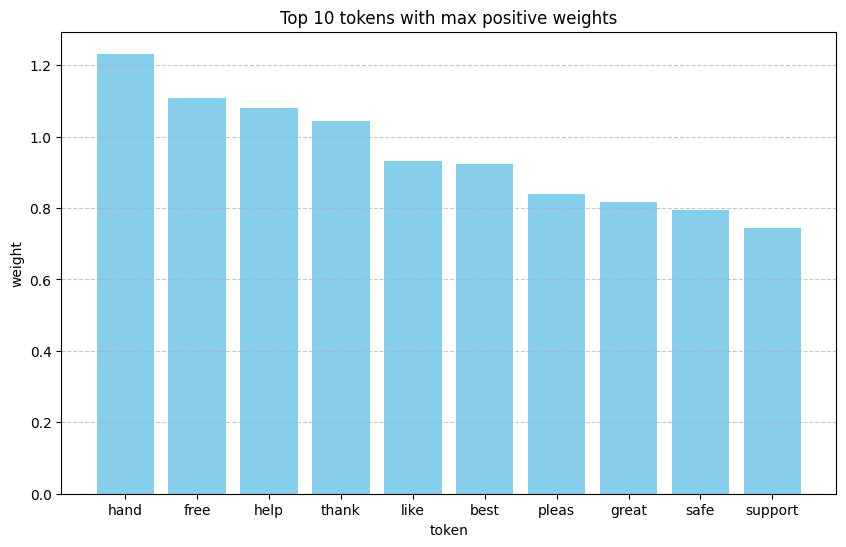

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(maxx['tokens'], maxx['weights'], color='skyblue')
plt.xlabel('token')
plt.ylabel('weight')
plt.title('Top 10 tokens with max positive weights')
plt.xticks(maxx['tokens'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Найдем 10 наибольших по модулю отрицательных весов

In [62]:
minn = new_df.nsmallest(10, 'weights')
minn

,tokens,weights
1163,crisi,-1.752453
2486,panic,-1.311949
2937,scam,-1.067288
2048,kill,-0.763717
1170,crude,-0.615644
3191,stop,-0.605137
1560,fear,-0.575225
1409,emerg,-0.563132
3673,wtf,-0.552442
1577,fight,-0.542246


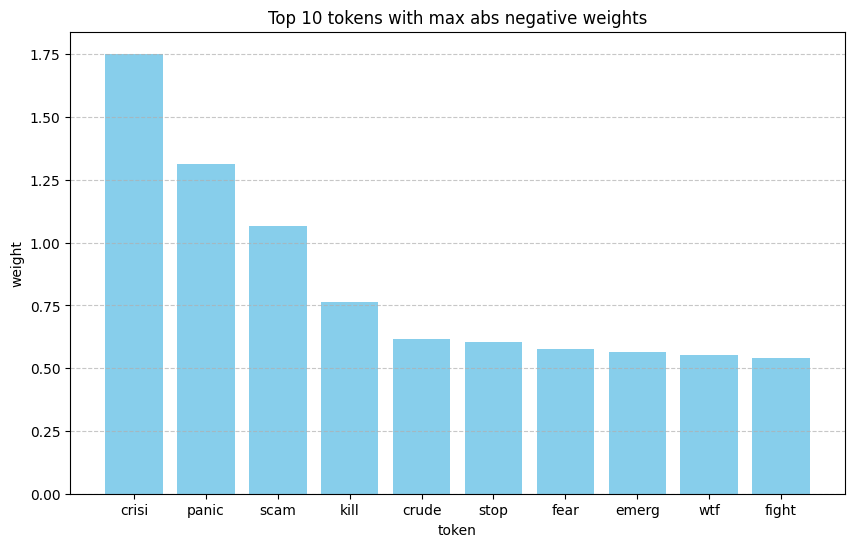

In [63]:
plt.figure(figsize=(10, 6))
plt.bar(minn['tokens'], np.abs(minn['weights']), color='skyblue')
plt.xlabel('token')
plt.ylabel('weight')
plt.title('Top 10 tokens with max abs negative weights')
plt.xticks(minn['tokens'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Ответ:** Можно заметить, что токены с максимальным положительным весом имеют очень положительный окрас. Например, это слова free, help, hand, thank, like. Среди токенов с наибольшим по модулю отрицательным весом можно найти такие слова, как crisi(s), panic, scam, etc. Они имеют резко негативный окрас, поэтому у них существенный отрицательный вес.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [64]:
train['UserName'].unique()

array([35178, 40819, 39249, ..., 41159, 29702,  7104])

In [65]:
train['ScreenName'].unique()

array([80130, 85771, 84201, ..., 86111, 74654, 52056])

**Ответ:** Можно заметить, что эти данные представляют собой числа, которые не несут смысловой нагрузки относительно эмоциональной окраски текста

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [66]:
train['TweetAt'].unique()

array(['06-04-2020', '10-04-2020', '09-04-2020', '19-03-2020',
       '18-03-2020', '01-04-2020', '23-03-2020', '07-04-2020',
       '21-03-2020', '20-03-2020', '17-03-2020', '14-04-2020',
       '22-03-2020', '04-04-2020', '26-03-2020', '16-03-2020',
       '25-03-2020', '28-03-2020', '05-04-2020', '02-04-2020',
       '13-04-2020', '11-04-2020', '08-04-2020', '24-03-2020',
       '03-04-2020', '27-03-2020', '12-04-2020', '31-03-2020',
       '29-03-2020', '30-03-2020'], dtype=object)

In [67]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')

<Axes: xlabel='TweetAt', ylabel='Count'>

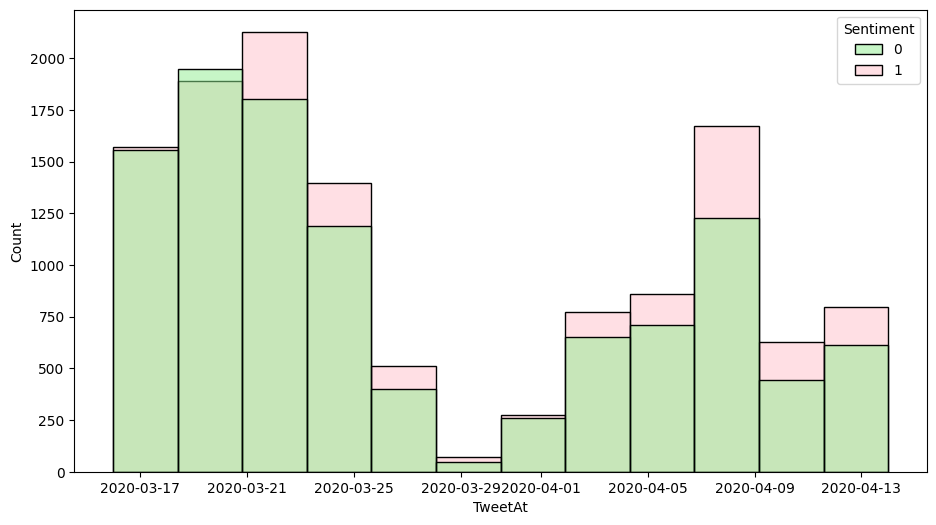

In [68]:
plt.figure(figsize=(11, 6))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', palette=['lightgreen', 'pink'], bins = 12)

**Ответ:** Можно заметить, что вне зависимости от даты, процентное соотношение положительных и негативных твиттов практически одинаковое, поэтому дата вряд ли будет являться важным признаком.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [69]:
len(train['Location'].unique())

7949

В тренировочной выборке 7949 уникальных геоположений на ~23000 записей.

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

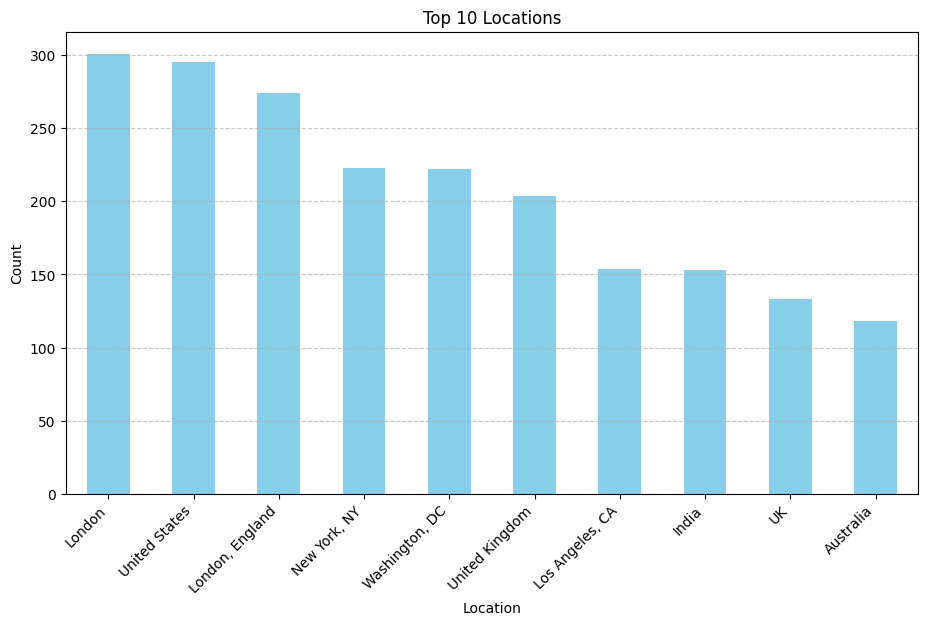

In [70]:
plt.figure(figsize=(11, 6))
location_counts = train['Location'].value_counts()
location_counts = location_counts.drop('Unknown', errors='ignore')
top_locations = location_counts.head(10)
top_locations.plot(kind='bar', color='skyblue')
plt.title('Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [71]:
def wider_location(location):
  if ',' in location:
    return location.split(', ')[-1]
  if len(location.split()) >= 2:
    return location.split()[-1]
  return location

train['WiderLocation'] = train['Location'].apply(wider_location)
test['WiderLocation'] = test['Location'].apply(wider_location)
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,WiderLocation
25621,35178,80130,Unknown,2020-04-06,Why we still want to buy so much stuff during ...,1,Unknown
30135,40819,85771,"Boston, MA HQ",2020-04-10,With driving even more usage a strong strategy...,1,MA HQ
28899,39249,84201,India,2020-04-09,@Canon_India I am very happy.. Great job by @C...,1,India
5989,11068,56020,"Mayfair, London, UK",2020-03-19,The U.S national debt will likely exceed $30 T...,0,UK
4367,9109,54061,WNC,2020-03-18,"Finally got to the grocery store. Honestly, wh...",1,WNC
...,...,...,...,...,...,...,...
20757,29120,74072,Unknown,2020-03-31,Football is in ruins right now.When it will re...,0,Unknown
32103,43291,88243,"Waterville, Ireland Austin, TX",2020-04-13,Hand sanitizer made here on the Skellig Coast!...,1,TX
30403,41159,86111,"Mumbai , Delhi India",2020-04-10,An initiative taken by our @GOLDENINITIATI1 ...,1,Delhi India
21243,29702,74654,Unknown,2020-04-01,Vile premiership players demanding full wages ...,0,Unknown


Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [72]:
from sklearn.preprocessing import OneHotEncoder

df_concat = pd.concat([train, test], axis=0)
location_counts = df_concat['WiderLocation'].value_counts()
frequent_locations = location_counts[location_counts > 1].index.tolist()
print(len(frequent_locations))

1346


1346 - количество мест, которые встречались более чем в одном твитте.

In [73]:
df_encoded = pd.get_dummies(df_concat['WiderLocation'])[frequent_locations]
df_encoded

,Unknown,USA,England,CA,India,UK,London,NY,Canada,States,...,mundo,Suva,WA USA,Northants,Heath,90210,dreams,Rock,why?,||somali|kenyan??
25621,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30135,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28899,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5989,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3220,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11637,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21149,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Разделим выборки обратно (складывали их вертикально, поэтому можем также разделить)

In [74]:
x_test = df_encoded.tail(10034)
x_train = df_encoded.head(23410)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [75]:
cv_matrix_train1 = np.concatenate([cv_train_scal, x_train], axis = 1)
cv_matrix_test1 = np.concatenate([cv_test_scal, x_test], axis = 1)

In [76]:
logreg = LogisticRegression(max_iter=200)
logreg.fit(cv_matrix_train1, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [77]:
acc_train = accuracy_score(logreg.predict(cv_matrix_train1), y_train)
acc_test = accuracy_score(logreg.predict(cv_matrix_test1), y_test)
print(f'train : {acc_train}\ntest : {acc_test}')

train : 0.9466894489534387
test : 0.8435319912298186


**Ответ:**  accuracy модели практически не изменилось, поэтому данный признак не является действительно важным при определении эмоциональной окраски текста твитта.

## Задание 8 Хорошее качество (Бонус 1 балл)

У меня не получилось добить качество 0.9, но оно все равно повысилось. А так как мне было лень удалять ячейки, so....

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [78]:
!pip install catboost

In [89]:
from catboost import CatBoostClassifier, cv
import xgboost as xgb

In [93]:
model = xgb.XGBClassifier(max_depth=7, n_estimators=1000)
model.fit(cv_matrix_train1, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [94]:
accuracy = model.score(cv_matrix_test1, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8688459238588798


In [95]:
model = CatBoostClassifier(iterations=1500, learning_rate=0.1, depth=8)
model.fit(cv_matrix_train1, y_train)

0:	learn: 0.6745228	total: 89.5ms	remaining: 2m 14s
1:	learn: 0.6583323	total: 165ms	remaining: 2m 3s
2:	learn: 0.6457610	total: 240ms	remaining: 1m 59s
3:	learn: 0.6349869	total: 321ms	remaining: 2m
4:	learn: 0.6277966	total: 396ms	remaining: 1m 58s
5:	learn: 0.6208899	total: 470ms	remaining: 1m 56s
6:	learn: 0.6146629	total: 548ms	remaining: 1m 56s
7:	learn: 0.6081049	total: 627ms	remaining: 1m 56s
8:	learn: 0.6029287	total: 699ms	remaining: 1m 55s
9:	learn: 0.5986802	total: 773ms	remaining: 1m 55s
10:	learn: 0.5941240	total: 851ms	remaining: 1m 55s
11:	learn: 0.5897870	total: 937ms	remaining: 1m 56s
12:	learn: 0.5851697	total: 1.03s	remaining: 1m 57s
13:	learn: 0.5811257	total: 1.1s	remaining: 1m 57s
14:	learn: 0.5777041	total: 1.18s	remaining: 1m 56s
15:	learn: 0.5743632	total: 1.26s	remaining: 1m 56s
16:	learn: 0.5711111	total: 1.33s	remaining: 1m 56s
17:	learn: 0.5680019	total: 1.4s	remaining: 1m 55s
18:	learn: 0.5656156	total: 1.48s	remaining: 1m 55s
19:	learn: 0.5634731	total: 

In [96]:
accuracy = model.score(cv_matrix_test1, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8752242375921866


ну почти....